In [1]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statistics
import requests
import concurrent.futures
from collections import Counter


In [2]:
def exploratory_stats(arrays, array_names):
    stats_list = []
    for idx, array in enumerate(arrays):
        array_name = array_names[idx]
        np_array = np.array(array, dtype=float)  # Ensure the array has a float dtype to handle NaNs

        mean = np.nanmean(np_array).round(2)
        median = np.nanmedian(np_array).round(2)
        min_value = np.nanmin(np_array).round(2)
        max_value = np.nanmax(np_array).round(2)
        std_dev = np.nanstd(np_array).round(2)
        q25 = np.nanpercentile(np_array, 25).round(2)
        q75 = np.nanpercentile(np_array, 75).round(2)

        stats_list.append([array_name, q25,mean,  q75, std_dev,  min_value,median, max_value])

    stats_df = pd.DataFrame(stats_list, columns=['Article Category','1st Quantile', 'Mean',  '3rd Quantile', 'Standard Deviation',  'Min','Median', 'Max'])
    
    return stats_df

In [3]:
whole_dict = {
    'protected': {
        'df':
        pd.read_csv(
            f'data/data_files/pipeline_steps/protected_articles/1_all_articles_fetched.csv'),
        'titles':
        pd.read_csv(f'data/data_files/pipeline_steps/protected_articles/0_protected_titles.csv')
    },
    'excellent': {
        'df':
        pd.read_csv(
            f'data/data_files/pipeline_steps/excellent_articles/1_all_articles_fetched.csv'),
        'titles':
        pd.read_csv(f'data/data_files/pipeline_steps/excellent_articles/0_excellent_titles.csv')
    },
    'readworthy': {
        'df':
        pd.read_csv(
            f'data/data_files/pipeline_steps/readworthy_articles/1_all_articles_fetched.csv'),
        'titles':
        pd.read_csv(f'data/data_files/pipeline_steps/readworthy_articles/0_readworthy_titles.csv')
    },
}


In [4]:
def print_common_items(list1, list2):
    # Convert the lists to sets
    set1 = set(list1)
    set2 = set(list2)

    # Find the intersection
    common_items = set1 & set2
    
    common_count = []
    # Print the common items
    for item in common_items:
        common_count.append(item)
    return common_count

In [5]:
a = print_common_items(whole_dict['excellent']['titles']['title'],
                   whole_dict['readworthy']['titles']['title'])
print((a))

['Blackpool Tower', 'Choanozoa', 'Höllengebirge']


In [6]:
excellent_art = pd.read_csv(f'data/data_files/pipeline_steps/excellent_articles/1_all_articles_fetched.csv')
readworthy_art = pd.read_csv(f'data/data_files/pipeline_steps/readworthy_articles/1_all_articles_fetched.csv')
protected_art = pd.read_csv(f'data/data_files/pipeline_steps/protected_articles/1_all_articles_fetched.csv')
max_len = max(len(excellent_art),len(readworthy_art),len(protected_art))
new_index = np.arange(max_len)

name_list = ['Protected Articles', 'Excellent Articles', 'Readworthy Articles']
category_name_list = ['Protected ', 'Excellent ', 'Readworthy']
char_count_article_df = pd.DataFrame()


### Topic Distribution with API

In [7]:
excellent_titles = pd.read_csv(
    f'data/data_files/pipeline_steps/excellent_articles/0_excellent_titles.csv')
readworthy_titles = pd.read_csv(
    f'data/data_files/pipeline_steps/readworthy_articles/0_readworthy_titles.csv')
protected_titles = pd.read_csv(
    f'data/data_files/pipeline_steps/protected_articles/0_protected_titles.csv')


## P31 Instances-Of

In [8]:
import concurrent.futures
from collections import Counter
import requests


def get_article_categories(title, lang="de"):
    url = f"https://{lang}.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "categories",
        "cllimit": "max"
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Extract the page from the query result
    page = list(data["query"]["pages"].values())[0]

    # Check if the page has categories
    if "categories" in page:
        categories = [
            cat["title"][10:] for cat in page["categories"] if cat["title"].startswith("Kategorie")
        ]
        categories_return = [cat for cat in categories if not cat.startswith('Wikipedia:')]
        return categories_return
    else:
        return None

def get_article_topic(title, lang="de"):

    def get_wikidata_id(title, lang="de"):
        url = "https://www.wikidata.org/w/api.php"
        params = {
            "action": "wbgetentities",
            "format": "json",
            "sites": f"{lang}wiki",
            "titles": title,
        }
        response = requests.get(url, params=params)
        data = response.json()

        if "entities" in data:
            entities = data["entities"]
            wikidata_id = None
            for entity in entities.values():
                if "id" in entity:
                    wikidata_id = entity["id"]
                    break
            return wikidata_id
        else:
            return None

    def get_label(wikidata_id, lang="de"):
        url = "https://www.wikidata.org/w/api.php"
        params = {
            "action": "wbgetentities",
            "format": "json",
            "ids": wikidata_id,
            "props": "labels",
            "languages": lang,
        }
        response = requests.get(url, params=params)
        data = response.json()

        label_data = data["entities"][wikidata_id]["labels"].get(lang)
        if label_data:
            return label_data["value"]
        else:
            return None

    def get_instance_or_subclass(wikidata_id, lang="de"):
        url = "https://www.wikidata.org/w/api.php"
        params = {
            "action": "wbgetentities",
            "format": "json",
            "ids": wikidata_id,
            "props": "claims",
            "languages": lang,
        }
        response = requests.get(url, params=params)
        data = response.json()

        instance_claims = data["entities"][wikidata_id]["claims"].get("P31", [])
        subclass_claims = data["entities"][wikidata_id]["claims"].get("P279", [])

        claims = instance_claims + subclass_claims
        if claims:
            claim_id = claims[0]["mainsnak"]["datavalue"]["value"]["id"]
            return get_label(claim_id, lang)
        else:
            return None

    wikidata_id = get_wikidata_id(title, lang)
    if wikidata_id:
        topic = get_instance_or_subclass(wikidata_id, lang)
        return topic
    else:
        return None


# Example usage
title = "Angela Merkel"
topic = get_article_topic(title)
print(f"Topic for '{title}':", topic)

def process_title(title):
    categories = get_article_categories(title) or []
    topic = get_article_topic(title)
    return categories, topic

def get_category_topic_counter(title_list, max_workers=16):
    category_list = []
    topic_list = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_title, title) for title in title_list]

        for future in concurrent.futures.as_completed(futures):
            try:
                categories, topic = future.result()
                category_list += categories
                topic_list.append(topic)
            except Exception as e:
                print(f"An error occurred: {e}")

    counted_categories = Counter(category_list)
    counted_topics = Counter(topic_list)

    # Convert the Counter object to a list of tuples (string, count)
    categories_result = list(counted_categories.items())
    topic_result = list(counted_topics.items())

    # Sort the results by counts in descending order
    categories_result.sort(key=lambda x: x[1], reverse=True)
    topic_result.sort(key=lambda x: x[1], reverse=True)

    return categories_result, topic_result


# Usage:
title_list = excellent_titles['title'].iloc[0:50]  # Your list of titles
categories_result, topic_result = get_category_topic_counter(title_list)


Topic for 'Angela Merkel': Mensch


In [9]:
exec_categories_result, exec_topic_result = get_category_topic_counter(excellent_titles['title'])
read_categories_result, read_topic_result = get_category_topic_counter(readworthy_titles['title'])
prot_categories_result, prot_topic_result = get_category_topic_counter(protected_titles['title'])


In [10]:
for key,item in whole_dict.items():
    print(item)
    cat,top = get_category_topic_counter(item['titles']['title'])
    whole_dict[key]['category_counter']=cat
    whole_dict[key]['topic_counter']=top
    

{'df':       Unnamed: 0                          title   bytes   
0              0                     Rudolf Heß   86509  \
1              1                           Popo     805   
2              2                         Kanake     309   
3              3                          Bitch    5369   
4              4                        Fisting    7432   
...          ...                            ...     ...   
2840        2840  Marie-Agnes Strack-Zimmermann   28388   
2841        2841                     Mike Tyson   83016   
2842        2842                       Toilette   51005   
2843        2843                    Braunwasser    1238   
2844        2844                   Zirkumzision  223530   

                                              sub_texts  
0     Rudolf Walter Richard Heß [] (* 26 April== 189...  
1                              Popo ist \nSiehe auch:\n  
2                    Kanake steht für:\n\nSiehe auch:\n  
3     Bitch  ist ein Begriff aus dem Englischen, der

In [11]:
for key,item in whole_dict.items():
    whole_dict[key]['category_counter'] = pd.DataFrame(whole_dict[key]['category_counter'],
                                                       columns=['category', 'size'])
    whole_dict[key]['category_counter']['share'] = round(whole_dict[key]['category_counter']['size'] / sum(whole_dict[key]['category_counter']['size']),4)
    whole_dict[key]['category_counter']['category_counter origin']=key

    whole_dict[key]['topic_counter'] = pd.DataFrame(whole_dict[key]['topic_counter'],
                                                    columns=['category', 'size'])
    whole_dict[key]['topic_counter']['share'] = round(whole_dict[key]['topic_counter']['size'] / sum(
        whole_dict[key]['topic_counter']['size']) ,4)
    whole_dict[key]['topic_counter']['article origin'] = key


In [13]:
def get_top_categories_and_others(whole_dict, top_n=7):
    # Sort the 'excellent' DataFrame by share and get the top 7 categories
    top_categories = whole_dict['excellent']['topic_counter'].sort_values(
        'share', ascending=False).head(top_n)['category'].tolist()

    new_dict = {}
    for key, df in whole_dict.items():
        df_top = df['topic_counter'][df['topic_counter']['category'].isin(top_categories)]
        others_share = df['topic_counter'][~df['topic_counter']['category'].isin(top_categories
                                                                                 )]['share'].sum()
        others_size = df['topic_counter'][~df['topic_counter']['category'].isin(top_categories
                                                                                )]['size'].sum()
        others_row = pd.DataFrame({
            'category': ['other'],
            'size': [others_size],
            'share': [others_share]
        })
        new_df = pd.concat([df_top, others_row], axis=0).reset_index(drop=True)
        new_dict[key] = {'topic_counter': new_df}

    return new_dict, top_categories


def plot_top_categories_sorted(whole_dict, top_categories):
    dfs = []
    for key, nested_dict in whole_dict.items():
        df = nested_dict['topic_counter']
        df['Origin'] = key
        dfs.append(df)

    combined_df = pd.concat(dfs, axis=0).reset_index(drop=True)

    # Sort the combined_df by the 'excellent' share value
    combined_df['sort_order'] = combined_df.apply(
        lambda row: whole_dict['excellent']['topic_counter'].loc[whole_dict['excellent'][
            'topic_counter']['category'] == row['category'], 'share'].values[0]
        if len(whole_dict['excellent']['topic_counter'].loc[whole_dict['excellent'][
            'topic_counter']['category'] == row['category'], 'share']) > 0 else 0,
        axis=1)
    combined_df = combined_df.sort_values(['sort_order'], ascending=[False]).drop('sort_order',
                                                                                  axis=1)

    # Filter out the 'other' category
    combined_df = combined_df[combined_df['category'] != 'other']

    # Define the custom order for the 'Origin' column
    type_order = ['protected', 'excellent', 'readworthy']
    combined_df['Origin'] = pd.Categorical(combined_df['Origin'],
                                           categories=type_order,
                                           ordered=True)

    # Rename the 'category' column to 'Class'
    combined_df = combined_df.rename(columns={'category': 'Class'})

    plt.figure(figsize=(10, 6))
    sns.barplot(data=combined_df, x='Class', y='share', hue='Origin', hue_order=type_order)
    plt.title('Top 7 Classes of Origin: Excellent')
    plt.xticks(rotation=45)
    plt.show()




def plot_top_categories_sorted_otherincl(whole_dict, top_categories):
    dfs = []
    for key, nested_dict in whole_dict.items():
        df = nested_dict['topic_counter']
        df['type'] = key
        dfs.append(df)

    combined_df = pd.concat(dfs, axis=0).reset_index(drop=True)

    # Sort the combined_df by the 'excellent' share value
    combined_df['sort_order'] = combined_df.apply(
        lambda row: whole_dict['excellent']['topic_counter'].loc[whole_dict['excellent'][
            'topic_counter']['category'] == row['category'], 'share'].values[0]
        if len(whole_dict['excellent']['topic_counter'].loc[whole_dict['excellent'][
            'topic_counter']['category'] == row['category'], 'share']) > 0 else 0,
        axis=1)
    combined_df = combined_df.sort_values(['sort_order', 'type'],
                                          ascending=[False, True]).drop('sort_order', axis=1)
    combined_df = combined_df.rename(columns={'category':'Category','share':'Share'})
    plt.figure(figsize=(10, 6))
    sns.barplot(data=combined_df, x='Category', y='Share', hue='type',)
    plt.title(
        'Top 7 Categories of Origin: Excellent '
    )
    plt.show()


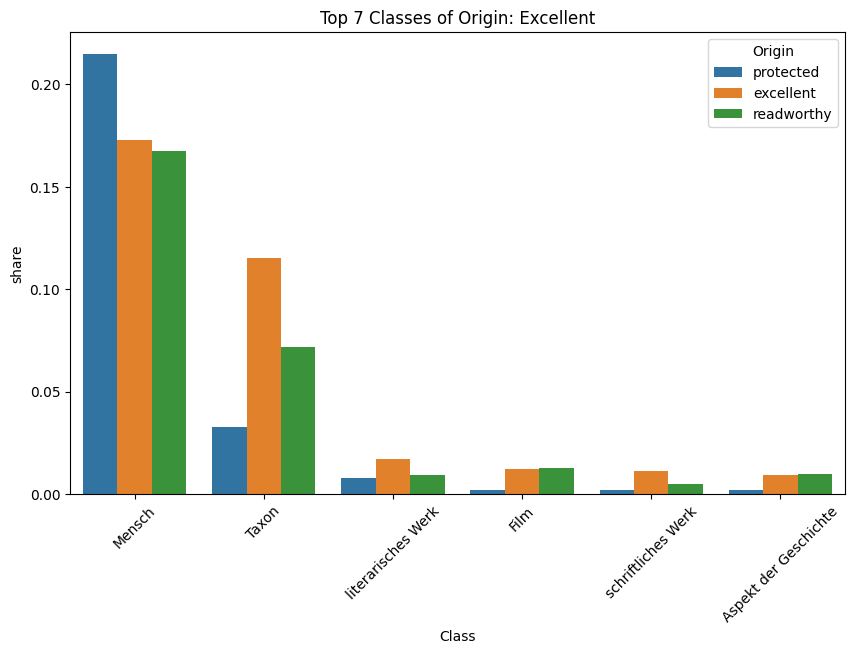

In [14]:
new_whole_dict, top_categories = get_top_categories_and_others(whole_dict)
plot_top_categories_sorted(new_whole_dict, top_categories)


In [15]:
print(whole_dict['readworthy']['topic_counter'])

                                      category  size   share article origin
0                                       Mensch   725  0.1677     readworthy
1                                         None   319  0.0738     readworthy
2                                        Taxon   311  0.0719     readworthy
3                               Kirchengebäude    62  0.0143     readworthy
4                                         Film    56  0.0130     readworthy
...                                        ...   ...     ...            ...
1290  Indianerstamm in den Vereinigten Staaten     1  0.0002     readworthy
1291                       Typ von Eigenschaft     1  0.0002     readworthy
1292                                     Traum     1  0.0002     readworthy
1293                          mentaler Prozess     1  0.0002     readworthy
1294                                Ontogenese     1  0.0002     readworthy

[1295 rows x 4 columns]


In [16]:
all_topics = pd.concat([whole_dict['excellent']['topic_counter'],whole_dict['readworthy']['topic_counter'],whole_dict['protected']['topic_counter']])
all_categories = pd.concat([
    whole_dict['excellent']['category_counter'], whole_dict['readworthy']['category_counter'],
    whole_dict['protected']['category_counter']
])
# all_topics.to_csv('all_topics_origins.csv')
# all_categories.to_csv('all_categories_origins.csv')
for key,item in whole_dict.items():
    display(whole_dict[key]['topic_counter'].head(10))
    display(whole_dict[key]['category_counter'].head(25))




,category,size,share,article origin
0,Mensch,611,0.2148,protected
1,None,569,0.2000,protected
2,Wikimedia-Begriffsklärungsseite,113,0.0397,protected
3,Taxon,93,0.0327,protected
4,Wikimedia-Liste,40,0.0141,protected
5,souveräner Staat,29,0.0102,protected
6,literarisches Werk,22,0.0077,protected
7,chemisches Element,21,0.0074,protected
8,Gewerbebetrieb,18,0.0063,protected
9,Asteroid,18,0.0063,protected


,category,size,share,category_counter origin
0,Mann,488,0.0313,protected
1,Deutscher,301,0.0193,protected
2,Frau,119,0.0076,protected
3,Begriffsklärung,114,0.0073,protected
4,Autor,85,0.0055,protected
5,Pseudonym,71,0.0046,protected
6,Filmschauspieler,70,0.0045,protected
7,US-Amerikaner,69,0.0044,protected
8,Literatur (Deutsch),66,0.0042,protected
9,Person als Namensgeber für einen Asteroiden,64,0.0041,protected


,category,size,share,article origin
0,Mensch,480,0.1728,excellent
1,Taxon,320,0.1152,excellent
2,None,173,0.0623,excellent
3,literarisches Werk,48,0.0173,excellent
4,Film,34,0.0122,excellent
5,schriftliches Werk,32,0.0115,excellent
6,Aspekt der Geschichte,26,0.0094,excellent
7,chemisches Element,26,0.0094,excellent
8,Gemälde,24,0.0086,excellent
9,Eisenbahnstrecke,24,0.0086,excellent


,category,size,share,category_counter origin
0,Mann,431,0.0228,excellent
1,Deutscher,138,0.0073,excellent
2,Autor,84,0.0044,excellent
3,Person als Namensgeber für einen Asteroiden,83,0.0044,excellent
4,US-Amerikaner,75,0.0040,excellent
5,Literatur (20. Jahrhundert),66,0.0035,excellent
6,Literatur (Deutsch),64,0.0034,excellent
7,Frau,50,0.0026,excellent
8,Literarisches Werk,50,0.0026,excellent
9,Disposition einer Orgel,38,0.0020,excellent


,category,size,share,article origin
0,Mensch,725,0.1677,readworthy
1,None,319,0.0738,readworthy
2,Taxon,311,0.0719,readworthy
3,Kirchengebäude,62,0.0143,readworthy
4,Film,56,0.0130,readworthy
5,Aspekt der Geschichte,43,0.0099,readworthy
6,literarisches Werk,41,0.0095,readworthy
7,Computerspiel,41,0.0095,readworthy
8,Eisenbahnstrecke,39,0.0090,readworthy
9,Album,36,0.0083,readworthy


,category,size,share,category_counter origin
0,Mann,597,0.0206,readworthy
1,Deutscher,234,0.0081,readworthy
2,Frau,127,0.0044,readworthy
3,Autor,112,0.0039,readworthy
4,US-Amerikaner,99,0.0034,readworthy
5,Kirchengebäude in Europa,76,0.0026,readworthy
6,Person als Namensgeber für einen Asteroiden,71,0.0025,readworthy
7,Literatur (Deutsch),68,0.0024,readworthy
8,Disposition einer Orgel,68,0.0024,readworthy
9,Literatur (20. Jahrhundert),62,0.0021,readworthy
